In [1]:
import os
import glob
import pickle
import tensorflow as tf    # used for creating tensors out of the dataset and training the model
import tensorflow_hub as hub    # downloading and using pre-trained 0models
import numpy as np
import h5py   # to manipulate the dataset as it's in `.h5` format
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report   # essential for model's evaluation
from sklearn.metrics import f1_score
from tqdm import tqdm   # getting a progress bar for an iterable object
import random

In [2]:
train_df64 = pd.read_csv("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/dataset/train64.csv")
# making rest columns which are not labeled good as damaged
train_df64["indication_type"] = train_df64.indication_type.apply(lambda row: "damaged" if row!="good" else "good")
train_df64["indication_value"] = train_df64.indication_value.apply(lambda row: 1 if row!=0 else 0)
train_df64.head()

,index,angle,indication_type,indication_value,split
0,48000,0,good,0,train
1,48001,80,good,0,train
2,48002,100,good,0,train
3,48003,100,good,0,train
4,48004,0,good,0,train


In [3]:
# determining proportion of good and damaged
train_df64.indication_type.value_counts(normalize=True).round(2)

indication_type
damaged    0.83
good       0.17
Name: proportion, dtype: float64

(array([0, 1]), [Text(0, 0, 'damaged'), Text(1, 0, 'good')])

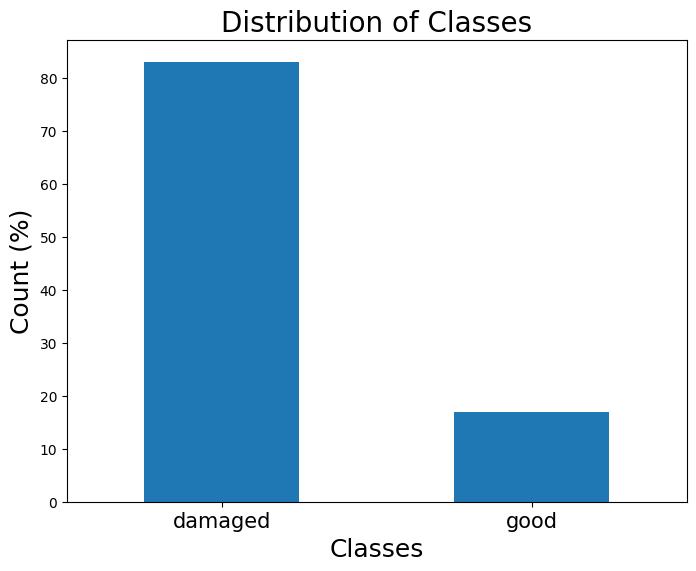

In [4]:
(train_df64.indication_type.value_counts(normalize=True).round(2)*100).to_frame().plot.bar(legend=False, figsize=(8, 6))
plt.xlabel('Classes', fontsize=18)
plt.ylabel("Count (%)", fontsize=18)
plt.title("Distribution of Classes", fontsize=20)
plt.xticks(rotation=0, fontsize=15)

In [5]:
# HDF5 file is opened and list of classes is retreived
# each and every class is iterated and images are created based on angles listed in csv
# train data generated in the directory separately into good and damaged folders where good images are augmented using horizontal and vertical flip
# similarly done for test directory but here augmentation is not performed

# create an object that will take the dataset and produce the dataset in a format required for tensorflow dataset's API
class H5ToStorage:
  def __init__(self, hdf_path, ds_name="train"):
    self.path = hdf_path

    self.classes = []
    with h5py.File(self.path, 'r') as hf:
      for class_ in hf:
        self.classes.append(class_)

    self.name = ds_name

  # a generator to load the (img, class, angle)
  def generate_img_arr(self):
    for class_ in self.classes:
      with h5py.File(self.path, 'r') as hf:
        for angle in hf[class_]:
            for img in hf[class_][f"{angle}"]:
                yield img, class_, angle

  # utilize the generator to create new images and load it back to Storage
  def generate_train_dirs(self):
    # create the dataset's directories
    path = "C:/Users/Ananya Doshi/OneDrive/Desktop/TextileDefect/working/train"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    random_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          for j in range(4):
            img_path = f"{path}/{label}/{i}_aug{j}.jpeg"
            # the "good" images in train directory are augmented since the proportion is very low
            img = random_flip(tf.expand_dims(np.squeeze(img), axis=2)*255., training=True)
            plt.imsave(img_path, np.squeeze(img), cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle
    return metadata

  def generate_test_dirs(self):
    # create the dataset's directories
    path = "C:/Users/Ananya Doshi/OneDrive/Desktop/TextileDefect/working/test"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          img_path = f"{path}/{label}/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle

    return metadata

  def to_storage(self):
    if self.name == "train":
      self.generate_train_dirs()

    elif self.name == "test":
      self.generate_test_dirs()

In [5]:
test_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/working/test"
train_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/working/train"

In [7]:
#  generate train data
train_gen = H5ToStorage("C:/Users/Ananya Doshi/OneDrive/Desktop/TextileDefect/dataset/matchingtDATASET_train_64.h5", "train")
train_dict = train_gen.to_storage()

In [8]:
#  generate test data
test_gen = H5ToStorage("C:/Users/Ananya Doshi/OneDrive/Desktop/TextileDefect/dataset/matchingtDATASET_test_64.h5", "test")
test_dict = test_gen.to_storage()

In [6]:
# train and test data pipelines created to load and preprocess images from the train and test directories respectively
# The dataset is then prefetched and cached for optimized performance.
# the ratio of train and test data split is 3:1
# train - 1080000 images and test - 36000 images


# create train data pipeline
IMG_SIZE = (64, 64) # define image size
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=IMG_SIZE,
                                                         color_mode="grayscale",
                                                         label_mode="int", #  label type is encoding of the form `[1, 2, 3, ...]`
                                                         batch_size=len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/working/train/good")) + len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/working/train/damaged")))
                                                        # Batch size is set to be the size of the whole dataset to make loading data into x_train, y_train easier.
class_names = train_data.class_names
print(f"The class_names are as follows: {class_names}")

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                        cache()

# create test data pipeline
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        color_mode="grayscale",
                                                        shuffle=False,
                                                        batch_size=len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/working/test/good")) + len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/working/test/damaged")),
                                                        label_mode="int")

test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                      cache()

Found 108000 files belonging to 2 classes.
The class_names are as follows: ['damaged', 'good']
Found 36000 files belonging to 2 classes.


In [ ]:
# check the proportions of classes
damaged_counts = 0
for _ in os.listdir(f"C:/Users/Ananya Doshi/OneDrive/Desktop/TextileDefect/working/train/damaged"):
  damaged_counts += 1

good_counts = 0
for _ in os.listdir(f"C:/Users/Ananya Doshi/OneDrive/Desktop/TextileDefect/working/train/good"):
  good_counts += 1

total = damaged_counts + good_counts

new_train_df64 = pd.Series({"damaged": damaged_counts/total,
                            "good": good_counts/total}).round(2)
new_train_df64

In [ ]:
# check the classes distribution
(new_train_df64*100).to_frame().plot.bar(legend=False, figsize=(8, 6))
plt.xlabel('Classes', fontsize=18)
plt.ylabel("Count (%)", fontsize=18)
plt.title("Distribution of Classes", fontsize=20)
plt.xticks(rotation=0, fontsize=15);

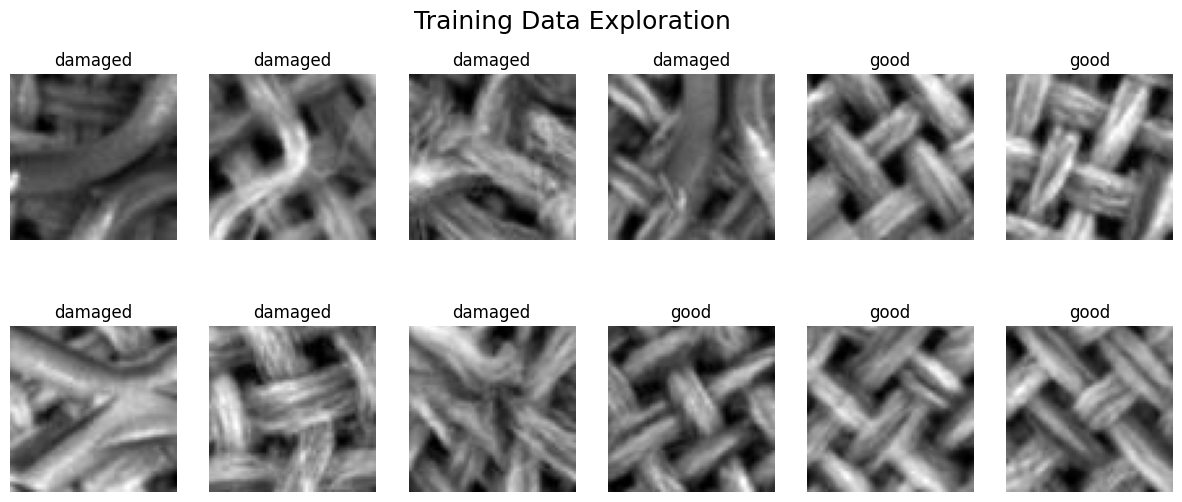

In [12]:
# explore the train data
def explore_data(n_rows, n_cols, figsize):
    count = 0
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize) # plot 20 figures
    fig.suptitle("Training Data Exploration", fontsize=18, y=0.95)
    for data, ax in zip(train_data.shuffle(10000).take(1).unbatch(), axs.ravel()):
        img, label = data

        ax.axis("off")
        ax.set_title(f"{class_names[label]}")
        ax.imshow(np.squeeze(img), cmap="gray")

        count+=1
        if count == n_rows*n_cols:
          break

explore_data(n_rows=2, n_cols=6, figsize=(15, 6))

In [7]:
# import the necessary packages
from imutils import paths
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
import random
from typing import Tuple

In [52]:
# images and quantified and preprocessed(features extracted) using pretrained inceptionV3 model

encoder_model = InceptionV3(include_top=True, weights='imagenet')

def quantify_image(image, model=encoder_model):
	image_np = cv2.copyMakeBorder(image, 117, 118, 117, 118, cv2.BORDER_CONSTANT)  #normalization
	image_np = image_np.reshape((1,299,299,3))  #images reshaped to default input image size of inceptionV3
	encoding = model(image_np)  #"model" used to extract features
	return encoding.numpy().reshape((1000))  # 1000 because there are 1000 classes in inceptionV3

def load_dataset(datasetPath, bins):
	imagePaths = list(paths.list_images(datasetPath))
	imagePaths = random.choices(imagePaths, k=5000)  #randomly chosen 5k images and converted to HSV color
	data = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image and convert it to the HSV color space
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
		features = quantify_image(image) #The quantify_image function is then used to extract features from each image.
		data.append(features) #features are added to a data list

	# return our data list as a NumPy array
	return np.array(data)

96112376/96112376 [==============================] - 7s 0us/step


Next, we train the model with a simple .fit() after loading in the dataset and initializing the model. We then write it into a .model file.

In [53]:
#ISOLATION FOREST_INCEPTION V3
# import the necessary packages
import pickle
from sklearn.ensemble import IsolationForest

args = {"dataset": "working/train/good", "model": "anomaly_detector.model"}

# load and quantify our image dataset - save imp features to data using load_dataset
print("[INFO] preparing dataset...")
data = load_dataset(args["dataset"], bins=(3, 3, 3))

# train the anomaly detection model
# The Isolation Forest model is instantiated with hyperparameters: 100 trees (n_estimators=100), a contamination rate(estimated abnormalities) of 0.1 (contamination=0.1), and a random seed of 42 (random_state=42
print("[INFO] fitting anomaly detection model...")
isolation_model = IsolationForest(n_estimators=100, contamination=0.1, # Contam originally 0.01, represents threshold
random_state=42)
isolation_model.fit(data)

# serialize the anomaly detection model to disk using pickle
f = open(args["model"], "wb")
f.write(pickle.dumps(isolation_model))
f.close()

[INFO] preparing dataset...
[INFO] fitting anomaly detection model...


After downloading the model, we test out the model on one of the images, which is the 16th test image.

In [54]:
import pickle
import cv2
import os
import matplotlib.pyplot as plt

[INFO] loading anomaly detection model...


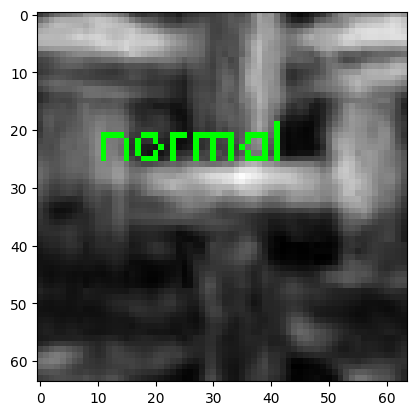

In [55]:

# construct the argument parser and parse the arguments
args = {"model":"anomaly_detector.model", "image": "working/test/damaged/"+os.listdir("working/test/damaged/")[15]}
# load the anomaly detection model
print("[INFO] loading anomaly detection model...")
isolation_model = pickle.loads(open(args["model"], "rb").read())


# load the input image, convert it to the HSV color space, and
# quantify the image in the *same manner* as we did during training
image = cv2.imread(args["image"])
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
features = quantify_image(hsv)

# use the anomaly detector model and extracted features to determine
# if the 16th example image is an anomaly or not
preds = isolation_model.predict([features])[0]
label = "anomaly" if preds == -1 else "normal"
color = (0, 0, 255) if preds == -1 else (0, 255, 0)

# draw the predicted label text on the original image
cv2.putText(image, label, (10,  25), cv2.FONT_HERSHEY_SIMPLEX,
	0.3, color, 1)

# display the image
plt.imshow(image)

Finally, we test this model's precision, recall, and f1 scores on 500 damaged and 500 good images from the test set.

In [56]:
true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = isolation_model.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = isolation_model.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1
        
precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"Precision: {precision}\nRecall: {recall}\nf1: {f1}")

Precision: 0.5979381443298969
Recall: 0.116
f1: 0.19430485762144054


Testing with Other Anomaly Detectors
Now, we will find the precision and recall on the test set using some other outlier detection models: namely, the Local Outlier Factor (LOF) algorithm, Gaussian Distributions (EllipticEnvelope), one-class SVM, and SGD one class SVM (stochastic gradient descent)

We will start out with Local Outlier Factor:

In [58]:
#LOCAL OUTLIER FACTOR INCEPTION V3
from sklearn.neighbors import LocalOutlierFactor
# LOF is used for outlier identification
# compares density at each data point by comparing it with its k nearest neighbours
# then it also determines distance to its k nearest neighbour
# Data points with high LOF scores are considered outliers

# contamination and novelty are hyperparameters
# contamination is used to indicate proportion of abnormalities
# novelty means that image is trained on images without outliers and will predict unseen data now
args = {"dataset": "working/train/good", "model": "anomaly_detector_LOF_INCEPTION_V3.model"}
LOF_model = LocalOutlierFactor(contamination=0.1, novelty=True)
LOF_model.fit(data)

true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = LOF_model.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = LOF_model.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1

# serialize the anomaly detection model to disk using pickle
f = open(args["model"], "wb")
f.write(pickle.dumps(LOF_model))
f.close()

precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"LOF Precision: {precision}\nLOF Recall: {recall}\nLOF f1: {f1}")

LOF Precision: 0.632258064516129
LOF Recall: 0.196
LOF f1: 0.29923664122137406


Next, we will try out outlier detection with a gaussian distribution using the Elliptic Envelope algorithm:

In [59]:
#ELLIPTIC ENVELOPE INCEPTION V3
from sklearn.covariance import EllipticEnvelope
import warnings
warnings.filterwarnings('ignore')

# This model assumes that mojority of data points follow a normal distribution
# mean and covariance is calculated to construct an alliptic envelope
# distance from each data point to center of distribution calculated
# points lying above given threshold are outliers
args = {"dataset": "working/train/good", "model": "anomaly_detector_ELLEPTIC_ENVELOPE_INCEPTION_V3.model"}
# The support_fraction parameter represents the proportion of data points to be included in the support of the robust estimator. 
Gauss_model = EllipticEnvelope(contamination=0.1, support_fraction=0.9, random_state=42)
Gauss_model.fit(data)

true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = Gauss_model.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = Gauss_model.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1

# serialize the anomaly detection model to disk using pickle
f = open(args["model"], "wb")
f.write(pickle.dumps(Gauss_model))
f.close()

precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"Gauss Precision: {precision}\nGauss Recall: {recall}\nGauss f1: {f1}")

Gauss Precision: 0.6355140186915887
Gauss Recall: 0.136
Gauss f1: 0.2240527182866557


Now, we will try the one-class SVM:

In [60]:
from sklearn.svm import OneClassSVM

args = {"dataset": "working/train/good", "model": "anomaly_detector_SVM_INCEPTION_V3.model"}
# used for outlier and novelty detection, meaning trained on good images and prediction on unseen data(classifies any anomoly to damaged)
SVM_model = OneClassSVM()
SVM_model.fit(data)

true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = SVM_model.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = SVM_model.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1

f = open(args["model"], "wb")
f.write(pickle.dumps(SVM_model))
f.close()


precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"SVM Precision: {precision}\nSVM Recall: {recall}\nSVM f1: {f1}")

SVM Precision: 0.4878048780487805
SVM Recall: 0.6
SVM f1: 0.538116591928251


Finally, we will try one class SVM with Stochastic Gradient Descent (SGD)

In [61]:
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM

# SGD involves iteratively updating the model parameters based on the gradient of the loss function calculated on a subset of the training data (a mini-batch). This allows for more scalable and efficient training, especially on large datasets.
args = {"dataset": "working/train/good", "model": "anomaly_detector_SGD_SVM_INCEPTION_V3.model"}
SGD_SVM_model = make_pipeline(
    Nystroem(random_state=42),
    SGDOneClassSVM(shuffle=True, random_state=42)
)
SGD_SVM_model.fit(data)

true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = SGD_SVM_model.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = SGD_SVM_model.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1

f = open(args["model"], "wb")
f.write(pickle.dumps(SGD_SVM_model))
f.close()

precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"SGD SVM Precision: {precision}\nSGD SVM Recall: {recall}\nSGD SVM f1: {f1}")

SGD SVM Precision: 0.5
SGD SVM Recall: 1.0
SGD SVM f1: 0.6666666666666666


From these f1 score results, one can see that the SGD SVM works best, followed by normal SVM, Local Outlier Factor, Elliptic Envelope, and the worst being the isolation forest.

Trying IsolationForest with ResNet Quantifier
Previously we used an InceptionNet V3 model to quantify images. Now, we will use a ResNet 101 model for this and compare their performances:

In [8]:
# import the necessary packages
from imutils import paths
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet101
import random
from typing import Tuple

In [9]:
encoder_model = ResNet101(include_top=True, weights='imagenet')

def quantify_image(image, model=encoder_model):
	image_np = cv2.copyMakeBorder(image, 80, 80, 80, 80, cv2.BORDER_CONSTANT)
	image_np = image_np.reshape((1,224,224,3))
	encoding = model(image_np)
	return encoding.numpy().reshape((1000))

def load_dataset(datasetPath, bins):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images (only a random 5000)
	imagePaths = list(paths.list_images(datasetPath))
	imagePaths = random.choices(imagePaths, k=5000)
	data = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image and convert it to the HSV color space
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

		# quantify the image and update the data list
		features = quantify_image(image)
		data.append(features)

	# return our data list as a NumPy array
	return np.array(data)

In [64]:
# USAGE
# python train_anomaly_detector.py --dataset forest --model anomaly_detector.model

# import the necessary packages
import pickle
from sklearn.ensemble import IsolationForest

# construct the argument parser and parse the arguments
args = {"dataset": "working/train/good", "model": "anomaly_detector_ISOLATION_resnet.model"}

# load and quantify our image dataset
print("[INFO] preparing dataset...")
data = load_dataset(args["dataset"], bins=(3, 3, 3))

# train the anomaly detection model
print("[INFO] fitting anomaly detection model...")
isolation_model_resnet = IsolationForest(n_estimators=100, contamination=0.1,         # Contam originally 0.01, represents threshold
	random_state=42)
isolation_model_resnet.fit(data)

# serialize the anomaly detection model to disk
f = open(args["model"], "wb")
f.write(pickle.dumps(isolation_model_resnet))
f.close()

[INFO] preparing dataset...
[INFO] fitting anomaly detection model...


[INFO] loading anomaly detection model...


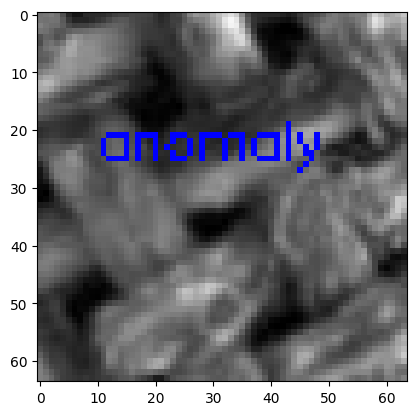

In [65]:
# USAGE
# python test_anomaly_detector.py --model anomaly_detector.model --image examples/highway_a836030.jpg

# import the necessary packages
import pickle
import cv2
import os
import matplotlib.pyplot as plt

# construct the argument parser and parse the arguments
args = {"model":"anomaly_detector_ISOLATION_resnet.model", "image": "working/test/damaged/"+os.listdir("working/test/damaged/")[0]}
# load the anomaly detection model
print("[INFO] loading anomaly detection model...")
isolation_model_resnet = pickle.loads(open(args["model"], "rb").read())

# load the input image, convert it to the HSV color space, and
# quantify the image in the *same manner* as we did during training
image = cv2.imread(args["image"])
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
features = quantify_image(hsv)

# use the anomaly detector model and extracted features to determine
# if the example image is an anomaly or not
preds = isolation_model_resnet.predict([features])[0]
label = "anomaly" if preds == -1 else "normal"
color = (0, 0, 255) if preds == -1 else (0, 255, 0)

# draw the predicted label text on the original image
cv2.putText(image, label, (10,  25), cv2.FONT_HERSHEY_SIMPLEX,
	0.3, color, 1)

# display the image
plt.imshow(image)

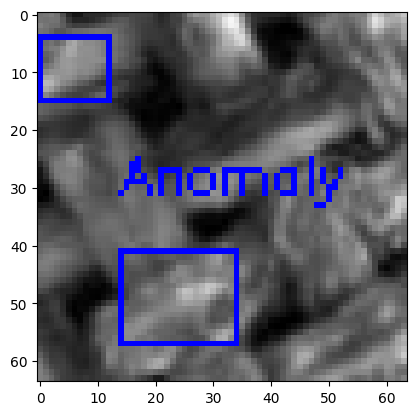

In [66]:
import cv2
import numpy as np

def find_anomaly_location(image, preds, min_contour_area=50, box_thickness=1):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to create a binary mask
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on minimum area
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    # Draw bounding box around each contour if it corresponds to an anomaly
    for contour in large_contours:
        x, y, w, h = cv2.boundingRect(contour)
        if preds == -1:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), box_thickness)  # Red box for anomalies
            cv2.putText(image, "Anomaly", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
        else:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), box_thickness)  # Green box for normal
            cv2.putText(image, "Normal", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

    return image

# Use this function after the existing code to visualize the anomaly location
image = cv2.imread(args["image"])
image_with_box = find_anomaly_location(image, preds)

# Display the image with the anomaly location
plt.imshow(image_with_box)
plt.show()

In [68]:
#BEST
true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = isolation_model_resnet.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = isolation_model_resnet.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1
        
precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"Precision: {precision}\nRecall: {recall}\nf1: {f1}")

Precision: 0.8042553191489362
Recall: 0.378
f1: 0.5142857142857142


As you can see, for the isolation forest, using ResNet101 works better than InceptionNetV3. Let's try SGD SVM:

In [69]:
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM

args = {"dataset": "working/train/good", "model": "anomaly_detector_SGD_SVM_RESNET.model"}
SGD_SVM_model_resnet = make_pipeline(
    Nystroem(random_state=42),
    SGDOneClassSVM(shuffle=True, random_state=42)
)
SGD_SVM_model_resnet.fit(data)

true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = SGD_SVM_model_resnet.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = SGD_SVM_model_resnet.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1

f = open(args["model"], "wb")
f.write(pickle.dumps(SGD_SVM_model_resnet))
f.close()

precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"SGD SVM Precision: {precision}\nSGD SVM Recall: {recall}\nSGD SVM f1: {f1}")

SGD SVM Precision: 0.501269035532995
SGD SVM Recall: 0.79
SGD SVM f1: 0.6133540372670808


In [ ]:
# USAGE
# python train_anomaly_detector.py --dataset forest --model anomaly_detector.model

# import the necessary packages
import pickle
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

args = {"dataset": "working/train/good", "model": "anomaly_detector_SVM_RESNET.model"}
# used for outlier and novelty detection, meaning trained on good images and prediction on unseen data(classifies any anomoly to damaged)
SVM_model_resnet = OneClassSVM()
SVM_model_resnet.fit(data)

# load and quantify our image dataset
print("[INFO] preparing dataset...")
data = load_dataset(args["dataset"], bins=(3, 3, 3))

# train the anomaly detection model
print("[INFO] fitting anomaly detection model...")
SVM_model_resnet = OneClassSVM(n_estimators=100, contamination=0.1,         # Contam originally 0.01, represents threshold
	random_state=42)
SVM_model_resnet.fit(data)

# serialize the anomaly detection model to disk
f = open(args["model"], "wb")
f.write(pickle.dumps(SVM_model_resnet))
f.close()

In [11]:
# Import necessary libraries
import pickle
from sklearn.covariance import EllipticEnvelope

# construct the argument parser and parse the arguments
args = {"dataset": "working/train/good", "model": "anomaly_detector_elliptic_resnet.model"}

# Load and quantify our image dataset
print("[INFO] Preparing dataset...")
data = load_dataset(args["dataset"], bins=(3, 3, 3))

# Train the anomaly detection model using Elliptic Envelope
print("[INFO] Fitting anomaly detection model...")
elliptic_model_resnet = EllipticEnvelope(contamination=0.1) # Adjust contamination according to your dataset
elliptic_model_resnet.fit(data)

# Serialize the anomaly detection model to disk

f = open(args["model"], "wb")
f.write(pickle.dumps(elliptic_model_resnet))
f.close()

[INFO] Preparing dataset...
[INFO] Fitting anomaly detection model...


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-47596.189037717151223 > -47597.011766545532737). You may want to try with a higher value of support_fraction (current value: 0.603).
  warnings.warn(


In [12]:
#BEST
true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = elliptic_model_resnet.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = elliptic_model_resnet.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1
        
precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"Precision: {precision}\nRecall: {recall}\nf1: {f1}")

Precision: 0.8214285714285714
Recall: 0.46
f1: 0.5897435897435898


In [40]:
# Import necessary libraries
import pickle
from sklearn.neighbors import LocalOutlierFactor


# construct the argument parser and parse the arguments
args = {"dataset": "working/train/good", "model": "anomaly_detector_LOF_resnet.model"}

# Load and quantify our image dataset
# print("[INFO] Preparing dataset...")
# data = load_dataset(args["dataset"], bins=(3, 3, 3))

# Train the anomaly detection model using Local Outlier Factor
print("[INFO] Fitting anomaly detection model...")
lof_model_resnet = LocalOutlierFactor(contamination=0.1,n_neighbors=5,novelty=True) # Adjust contamination according to your dataset
lof_model_resnet.fit(data)

# Serialize the anomaly detection model to disk

f = open(args["model"], "wb")
f.write(pickle.dumps(lof_model_resnet))
f.close()


[INFO] Fitting anomaly detection model...


In [37]:
# print(len(data))

5000


In [41]:
# #BEST
# true_positive = 0
# false_positive = 0
# false_negative = 0
# for i in range(500):
#     def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
#     def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
#     def_features = quantify_image(def_hsv)
#     def_preds = lof_model_resnet.fit_predict([def_features])[0]
#     def_label = "anomaly" if def_preds == -1 else "normal"
#     if def_label == "anomaly":
#         true_positive += 1
#     else:
#         false_negative += 1
        
#     norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
#     norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
#     norm_features = quantify_image(norm_hsv)
#     norm_preds = lof_model_resnet.fit_predict([norm_features])[0]
#     norm_label = "anomaly" if norm_preds == -1 else "normal"
#     if norm_label == "anomaly": false_positive += 1
        
# precision = true_positive/ (true_positive + false_positive)
# recall = true_positive/ (true_positive + false_negative)
# f1 = 2 * ((precision*recall)/(precision+recall))

# print(f"Precision: {precision}\nRecall: {recall}\nf1: {f1}")





# Perform predictions for both normal and anomaly images
true_positive = 0
false_positive = 0
false_negative = 0

for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = lof_model_resnet.predict([def_features])[0]  # Use predict instead of fit_predict
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = lof_model_resnet.predict([norm_features])[0]  # Use predict instead of fit_predict
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly":
        false_positive += 1

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"Precision: {precision}\nRecall: {recall}\nf1: {f1}")

Precision: 0.6984732824427481
Recall: 0.366
f1: 0.4803149606299212


In [15]:
# Import necessary libraries
import pickle
from sklearn.svm import OneClassSVM

# construct the argument parser and parse the arguments
args = {"dataset": "working/train/good", "model": "anomaly_detector_oneClassSVM_resnet.model"}

# Load and quantify our image dataset
# print("[INFO] Preparing dataset...")
# data = load_dataset(args["dataset"], bins=(3, 3, 3))

# Train the anomaly detection model using One-Class SVM
print("[INFO] Fitting anomaly detection model...")
svm_model_resnet = OneClassSVM(nu=0.1)  # Adjust nu according to your dataset
svm_model_resnet.fit(data)

# Serialize the anomaly detection model to disk
f = open(args["model"], "wb")
f.write(pickle.dumps(svm_model_resnet))
f.close()


[INFO] Fitting anomaly detection model...


In [16]:
#BEST
true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = svm_model_resnet.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = svm_model_resnet.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1
        
precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"Precision: {precision}\nRecall: {recall}\nf1: {f1}")

Precision: 0.751269035532995
Recall: 0.296
f1: 0.42467718794835


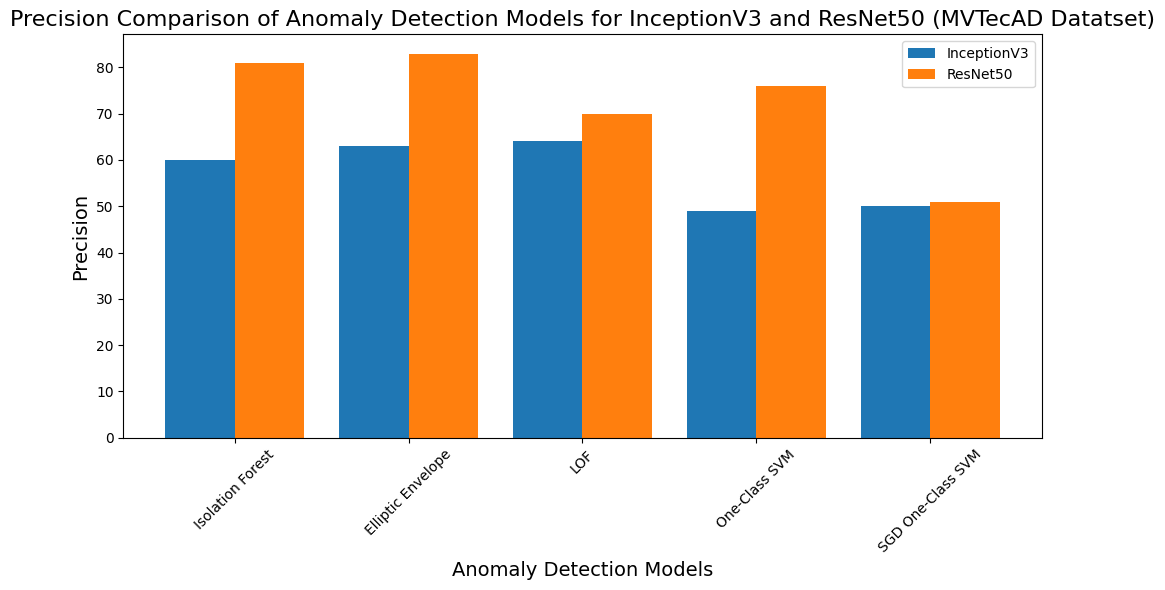

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Define precision scores for InceptionV3 and ResNet50 quantifiers
precision_inceptionv3 = [60, 63,
                         64, 49,
                         50]
precision_resnet50 = [81, 83,
                      70, 76,
                      51]

# Define models
models = ['Isolation Forest', 'Elliptic Envelope', 'LOF', 'One-Class SVM', 'SGD One-Class SVM']
num_models = len(models)

# Plotting the precision scores for InceptionV3 quantifier
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_models), precision_inceptionv3, width=0.4, align='center', label='InceptionV3')

# Plotting the precision scores for ResNet50 quantifier
plt.bar(np.arange(num_models) + 0.4, precision_resnet50, width=0.4, align='center', label='ResNet50')

# Adding labels and title
plt.xlabel('Anomaly Detection Models', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision Comparison of Anomaly Detection Models for InceptionV3 and ResNet50 (MVTecAD Datatset)', fontsize=16)
plt.xticks(np.arange(num_models) + 0.2, models, rotation=45)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()
